In [89]:
# %%
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import glob
from astropy.table import Table
import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
import inspect
import matplotlib.pyplot as plt
from astropy.time import Time

# %%
snrcut = 3
source = 'MOSFiT'
fittype = 'SLSN-I'
verbose = True

# %%
models = sorted(glob.glob(f'../model/PLAsTiCC/{fittype}/SIMSED.{fittype}/*.fits'))
print(f"{len(models)} models found") 

# %%
# path_sedinfo = f'../model/PLAsTiCC/{fittype}/SIMSED.{fittype}/SED.INFO'
# infotbl = tablize_sedinfo(path_sedinfo, models)
from astropy.io import ascii
infotbl = ascii.read(f'../model/PLAsTiCC/{fittype}/sedinfo.dat')
infotbl['model'] = models

# %%
ii = 10
model = models[ii]
_mdtbl = Table.read(model)

indx = np.where(
    (_mdtbl['col1'] <= 30) &
    (_mdtbl['col2'] >= 2000) &
    (_mdtbl['col2'] <= 11000)
    # (_mdtbl['col2'] <= 10000)
)

mdtbl = _mdtbl[indx]
phasearr = np.unique(mdtbl['col1'])
lamarr = np.unique(mdtbl['col2'])
number_of_unique_phase, number_of_unique_wavelength = len(phasearr), len(lamarr)
flux2darr = mdtbl['col3'].reshape(number_of_unique_phase, number_of_unique_wavelength)

print(f"Table length: {len(_mdtbl)} --> {len(mdtbl)}")

# %%
param_keys = infotbl.keys()[2:]
param_keys

# %%
# 데이터 변환
X, y = prepare_rf_train_data(infotbl, param_keys, phasearr, number_of_unique_phase, number_of_unique_wavelength, phase_upper=np.max(phasearr), lam_lower=np.min(lamarr), lam_upper=np.max(lamarr))
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# %%
# Random Forest 모델 생성 및 훈련
print("# Starting training...")
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# %%
# 테스트 데이터에 대한 예측 수행
y_pred = rf.predict(X_test)


# %% [markdown]
# # Fitting the model

# %% [markdown]
# ## Input data

# %%
register_custom_filters_on_speclite('../util')

# %%
intype = 'kn'
indist = 40
inexptime = 180
# group = 'broad_ugriz'
group = 'med25nm'
if group == 'med25nm':
	filterset_group = filterlist_med25nm
elif group == 'broad_griz':
	filterset_group = filterlist_griz
elif group == 'broad_ugriz':
	filterset_group = filterlist_ugriz
filterset = [f"{group}-{filte}" for filte, _, group in filterset_group]
bands = speclite.filters.load_filters(*filterset)

if 'med' in bands.names[0]:
	#    Medium-band
	bandwidth = 250 # [AA]
	lammin = 3000
	lammax = 10000
else:
	#	Broad-band
	bandwidth = 1000 # [AA]
	lammin = 2000
	lammax = 12000

lamstep = bandwidth/10
# lamarr = np.arange(lammin, lammax+lamstep, lamstep)
# _lamarr = np.arange(lammin, lammax+lamstep, 10)

print(f"lam: {lammin:.3f} - {lammax:.3f} AA")
print(f"lamstep: {lamstep:g} AA")
print(f"n_lam: {len(lamarr)}")
#%%

960 models found
Table length: 29800 --> 2520
Use `med25nm`, `med50nm`, `broad` as `group_name`
lam: 3000.000 - 10000.000 AA
lamstep: 25 AA
n_lam: 180


In [91]:
y_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평균 제곱 오차 (MSE) 계산
mse = mean_squared_error(y_test, y_pred)
print("평균 제곱 오차 (MSE):", mse)

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(y_test, y_pred)
print("평균 절대 오차 (MAE):", mae)

# 결정 계수 (R-squared) 계산
r2 = r2_score(y_test, y_pred)
print("결정 계수 (R-squared):", r2)

평균 제곱 오차 (MSE): 1.142063953358179e+80
평균 절대 오차 (MAE): 3.545590466973702e+39
결정 계수 (R-squared): 0.9422063277541481


In [92]:
# %%
if group == 'med25nm':
	#	Medium-band
	path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
else:
	#	Broad-band
	path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/broad'
path_output = f'../fit_result/{intype}2{fittype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
if not os.path.exists(path_output):
	os.makedirs(path_output)
outfits = f"{path_output}/fit_result.fits"

# %%
intablelist = sorted(glob.glob(f"{path_input}/obs.*.fits"))
print(f"{len(intablelist)} input tables found")

# %%
outbl = Table()
#	Input data
outbl['input_table'] = [os.path.basename(intable) for intable in intablelist]
#	Detection / Fit
outbl['ndet'] = 0
outbl['det_filters'] = " "*200
outbl['det'] = False
outbl['fit'] = False
#	Fitted Parameters
outbl['z'] = 0.
outbl['t'] = 0.
for key in param_keys:
	outbl[key] = 0.
#	Error
outbl['zerr'] = 0.
outbl['terr'] = 0.
for key in param_keys:
	outbl[f"{key}err"] = 0.

#	Fit Results
outbl['free_params'] = 0
outbl['dof'] = 0
outbl['chisq'] = 0.
outbl['chisqdof'] = 0.
outbl['bic'] = 0.
#	Meta
outbl.meta['fittype'] = fittype
outbl.meta['source'] = source
outbl.meta['intype'] = intype
outbl.meta['indist[Mpc]'] = indist
outbl.meta['inexptime[s]'] = inexptime
outbl.meta['group'] = group
outbl.meta['date'] = Time.now().isot

# %%
#	Temp Table
_intbl = Table.read(intablelist[0])
for key, val in _intbl.meta.items():
	if key in ['MD', 'VD', 'MW', 'VW', 'ANG', 'PHASE', 'REDSHIFT',]:
		if type(val) is str:
			outbl[key] = ' '*10
		elif type(val) is float:
			outbl[key] = 0.0
		elif type(val) is int:
			outbl[key] = 0

# %%
# def func(x, z, t, M_V, t_rise, dm15B, dm15R):
# def func(x, z, t, pc1, pc2, pc3):
def func(x, z, t, bfield, mns, pspin, kappa, kappagamma, mej, temp, vej):

	new_data = np.array(
		[[bfield, mns, pspin, kappa, kappagamma, mej, temp, vej, t]]
		)

	#	Spectrum : wavelength & flux
	flam = rf.predict(new_data)[0]*8.358E-41

	#	Redshifted
	(zspappflam, zsplam) = apply_redshift_on_spectrum(flam*flamunit, lamarr*lamunit, z, z0=0)
	mags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam))

	spmag = np.array([mags[key][0] for key in mags.keys()])
	spfnu = (spmag*u.ABmag).to(u.uJy).value
	# print(f"z={z:.3f}, t={t:.3f}, bfield={bfield:.3f}, mns={mns:.3f}, pspin={pspin:.3f}, kappa={kappa:.3f}, kappagamma={kappagamma:.3f}, mej={mej:.3f}, temp={temp:.3f}, vej={vej:.3f}")
	return spfnu

3600 input tables found


# `curve_fit`

In [110]:
ii = 50
intable = intablelist[ii]
st = time.time()

# %%
print(f"{os.path.basename(intable)} ({inexptime}s) --> {fittype}")
intbl = Table.read(intable)

# %%
indx_det = np.where(intbl['snr']>snrcut)
filterlist_det = list(intbl['filter'][indx_det])
filterlist_str = ",".join(filterlist_det)

# %%
filterset = [f"{group}-{filte}" for filte, _, group in filterset_group if filte in filterlist_det]
bands = speclite.filters.load_filters(*filterset)

# %%
# %%
ndet = len(filterset)
detection = np.any(intbl['snr'] > 5)
if verbose:
	print(f"number of detections: {ndet}")
	print(f"detection: {detection}")

# %%
xdata = intbl['fnuobs'].data[indx_det]
ydata = xdata
sigma = intbl['fnuerr'].data[indx_det]

# %% [markdown]
# - x, z, t, M_V, t_rise, dm15B, dm15R

# %%
if detection:
	#	Initial Guess
	p0list = [0.1, 5]
	for key in param_keys:
		p0list.append(np.mean(infotbl[key]))
	p0 = tuple(p0list)
	# print(p0)
	# p0 = (
	# 	0.01, 0, np.mean(infotbl['M_V']), np.mean(infotbl['t_rise']), np.mean(infotbl['dm15B']), np.mean(infotbl['dm15B']),
	# )
	#	Boundaries
	loboundlist = [0.0, np.min(phasearr)]
	upboundlist = [3.0, 30]

	for key in param_keys:
		loboundlist.append(np.min(infotbl[key]))
		upboundlist.append(np.max(infotbl[key]))

	bounds = (
		tuple(loboundlist),
		tuple(upboundlist),
	)
	# print(bounds)
	# bounds = (
	# 	(0.0, -25, np.min(infotbl['M_V']), np.min(infotbl['t_rise']), np.min(infotbl['dm15B']), np.min(infotbl['dm15R'])),
	# 	(1.0, 30,      np.max(infotbl['M_V']), np.max(infotbl['t_rise']), np.max(infotbl['dm15B']), np.max(infotbl['dm15R'])),
	# )

	n_free_param = len(inspect.signature(func).parameters)-1


	fit = False
	try:
		popt, pcov = curve_fit(
			func,
			xdata=xdata,
			ydata=ydata,
			sigma=sigma,
			p0=p0,
			absolute_sigma=True,
			check_finite=True,
			bounds=bounds,
			method='trf',
			# max_nfev=1e4,
			# verbose=2,
			# x_scale=np.array([0.1, 1, 1, 1, 1, 0.1, 10, 10, 1000, 1000])/1,
			# f_scale=0.01,
			# x_scale='jac',
			# xtol=1e-30,
			# ftol=1e-20,
			# gtol=1e-8,
			# diff_step=25,
			diff_step=1.10,
			# verbose=2,
			# loss='arctan'
		)
		fit = True
	except Exception as e:
		# print(e)
		outlog = f"{path_output}/{os.path.basename(intable).replace('obs', 'fit').replace('fits', 'log')}"
		f = open(outlog, 'w')
		f.write(str(e))
		f.close()
		fit = False



	if fit:
		#	Fitting result
		r = ydata.data - func(xdata, *popt)
		n_free_param = len(inspect.signature(func).parameters)-1
		dof = ndet - n_free_param
		chisq_i = (r / sigma) ** 2
		chisq = np.sum(chisq_i)
		chisqdof = chisq/dof
		bic = chisq + n_free_param*np.log(ndet)
		perr = np.sqrt(np.diag(pcov))


		z, t, bfield, mns, pspin, kappa, kappagamma, mej, temp, vej = popt
		if verbose:
			print(f"ndet={ndet}")
			print(f"chisq={chisq:.3}")
			print(f"chisqdof={chisqdof:.3}")
			print(f"bic={bic:.3}")
			print(f"z={z:.3}")
			print(f"t={t:.3}")
			print(f"bfield={bfield:.3}")
			print(f"mns={mns:.3}")
			print(f"pspin={pspin:.3}")
			print(f"kappa={kappa:.3}")
			print(f"kappagamma={kappagamma:.3}")
			print(f"mej={mej:.3}")
			print(f"temp={temp:.3}")

obs.000050.fits (180s) --> SLSN-I
number of detections: 18
detection: True
ndet=18
chisq=5.11e+02
chisqdof=63.9
bic=5.4e+02
z=0.142
t=5.06
bfield=1.78
mns=1.82
pspin=2.82
kappa=0.131
kappagamma=12.6
mej=10.4
temp=5.89e+03


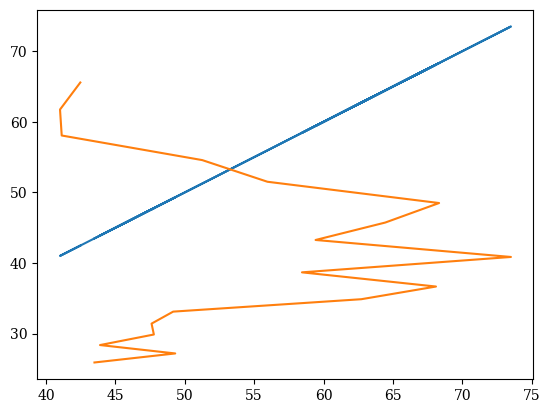

In [111]:
plt.plot(xdata, ydata)
plt.plot(xdata, func(xdata, *popt))

# `lmfit`

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model


# 피팅에 사용할 데이터 생성
x = xdata
y = ydata

# lmfit 모델 생성
model = Model(func)

# 초기 파라미터 추정
params = model.make_params(z=0.1, t=5, bfield=np.mean(infotbl['bfield']), mns=np.mean(infotbl['mns']), pspin=np.mean(infotbl['pspin']), kappa=np.mean(infotbl['kappa']), kappagamma=np.mean(infotbl['kappagamma']), mej=np.mean(infotbl['mej']), temp=np.mean(infotbl['temp']), vej=np.mean(infotbl['vej']))

# 경계값 설정
params['z'].min = bounds[0][0]
params['z'].max = bounds[1][0]
params['t'].min = bounds[0][1]
params['t'].max = bounds[1][1]
params['bfield'].min = bounds[0][2]
params['bfield'].max = bounds[1][2]
params['mns'].min = bounds[0][3]
params['mns'].max = bounds[1][3]
params['pspin'].min = bounds[0][4]
params['pspin'].max = bounds[1][4]
params['kappa'].min = bounds[0][5]
params['kappa'].max = bounds[1][5]
params['kappagamma'].min = bounds[0][6]
params['kappagamma'].max = bounds[1][6]
params['mej'].min = bounds[0][7]
params['mej'].max = bounds[1][7]
params['temp'].min = bounds[0][8]
params['temp'].max = bounds[1][8]
params['vej'].min = bounds[0][9]
params['vej'].max = bounds[1][9]

params

name,value,initial value,min,max,vary
z,0.10000000,0.1,0.00000000,3.00000000,True
t,5.00000000,5.0,2.00800000,30.0000000,True
bfield,1.81589741,1.815897406698609,0.00905408,41.0182086,True
mns,1.83790704,1.8379070443982812,1.17500526,2.91959160,True
pspin,2.88420037,2.8842003658159894,1.01370801,12.6913737,True
kappa,0.12744800,0.12744800360754438,0.05323908,0.19976185,True
kappagamma,16.3651786,16.36517855223411,1.6026e-05,5025.91754,True
mej,7.00462228,7.004622278183375,1.01126904,63.1928255,True
temp,6027.15963,6027.1596285439055,2925.37517,13092.4582,True
vej,9272.24505,9272.245049032657,5023.07279,21828.1355,True


In [115]:
from lmfit import Model

# 피팅에 사용할 데이터 생성
x = xdata
y = ydata
# lmfit 모델 생성
model = Model(func)
# 초기 파라미터 추정
# del params
params = model.make_params()
for key in params.keys():
	if key == 'z':
		init_val = 0.01
		lower_val = 0.0001
		upper_val = 1.0
	elif key == 't':
		init_val = np.median(phasearr)
		lower_val = phasearr.min()
		upper_val = phasearr.max()
	else:
		init_val = np.median(infotbl[key])
		lower_val = np.min(infotbl[key])
		upper_val = infotbl[key].max()
	# print(key, init_val, lower_val, upper_val)
	params[key].init_value = init_val
	params[key].min = lower_val
	params[key].max = upper_val
params

name,value,initial value,min,max,vary
z,-inf,0.01,1.0000e-04,1.00000000,True
t,-inf,15.059999999999999,2.00800000,28.1120000,True
bfield,-inf,0.8562174957124999,0.00905408,41.0182086,True
mns,-inf,1.82280232538,1.17500526,2.91959160,True
pspin,-inf,2.4589365510650003,1.01370801,12.6913737,True
kappa,-inf,0.125286773831,0.05323908,0.19976185,True
kappagamma,-inf,0.46428830595799997,1.6026e-05,5025.91754,True
mej,-inf,4.8208614251299995,1.01126904,63.1928255,True
temp,-inf,5895.49515813,2925.37517,13092.4582,True
vej,-inf,8786.764347285,5023.07279,21828.1355,True


[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 142
    # data points      = 18
    # variables        = 10
    chi-square         = 633.442349
    reduced chi-square = 79.1802937
    Akaike info crit   = 84.0943502
    Bayesian info crit = 92.9980678
    R-squared          = 0.65467538
##  Warning: uncertainties could not be estimated:
    mns:         at initial value
    mns:         at boundary
[[Variables]]
    z:           0.23401041 (init = 0.0001)
    t:           3.65138755 (init = 2.008)
    bfield:      7.37337742 (init = 0.009054078)
    mns:         1.17500791 (init = 1.175005)
    pspin:       5.35944194 (init = 1.013708)
    kappa:       0.05349296 (init = 0.05323908)
    kappagamma:  1921.90129 (init = 1.602647e-05)
    mej:         22.2630275 (init = 1.011269)
    temp:        2925.51798 (init = 2925.375)
    vej:         8453.03706 (init = 5023.073)
Chi-square: 633.4423494239691
Degrees of Freedom: 8
Reduced Chi-sq

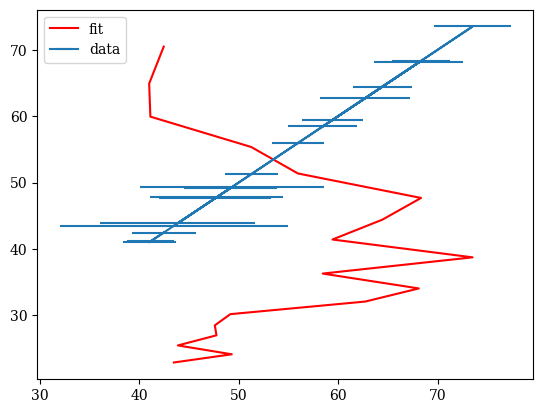

In [116]:
# 데이터 피팅
result = model.fit(
    y,
    params,
    x=x,
    weights=1/sigma,
    method='cobyla',
    calc_covar=True,
    # method='leastsq'
    # method='nelder'
    )

# 카이제곱 계산
chi_square = np.sum(result.residual**2)

# 자유도 계산
dof = len(x) - len(result.params)

# 축소 카이제곱 계산
reduced_chi_square = chi_square / dof

# 파라미터 에러 계산
# param_errors = np.sqrt(np.diag(result.covar))

# 결과 출력
print(result.fit_report())
print("Chi-square:", chi_square)
print("Degrees of Freedom:", dof)
print("Reduced Chi-square:", reduced_chi_square)
# print("Parameter Errors:", param_errors)

# 피팅 결과 시각화
# plt.plot(x, y, 'bo', label='data')
plt.errorbar(x, y, xerr=sigma, label='data')
plt.plot(x, result.best_fit, 'r-', label='fit')
plt.legend()


## Method Test

In [42]:
methodlist = [
	'leastsq',
	'nelder',
	'powell',
	'cg',
	'newton',
	'cobyla',
	'bfgsb',
	'tnc',
	'trust-ncg',
	'trust-exact',
	'trust-krylov',
	'trust-constr',
	'dogleg',
	'slsqp',
	'differential_evolution',
	'brute',
	'ampgo',
	'shgo',
	'dual_annealing',
]

fit_result_dict = {}
failist = []

for method in methodlist:
	try:
		st = time.time()
		# 데이터 피팅
		result = model.fit(
			y,
			params,
			x=x,
			method=method,
			# method='nelder'
			)

		# 카이제곱 계산
		chi_square = np.sum(result.residual**2)

		# 자유도 계산
		dof = len(x) - len(result.params)

		# 축소 카이제곱 계산
		reduced_chi_square = chi_square / dof

		# 파라미터 에러 계산
		# param_errors = np.sqrt(np.diag(result.covar))

		# 결과 출력
		print(f"="*60)
		print(method)
		print(result.fit_report())
		# print("Chi-square:", chi_square)
		# print("Degrees of Freedom:", dof)
		# print("Reduced Chi-square:", reduced_chi_square)
		fit_result_dict[method] = {
			'method': method,
			'time': time.time() - st,
			'chi_square': chi_square,
			'dof': dof,
			'reduced_chi_square': reduced_chi_square,
		}
	except Exception as e:
		failist.append(method)
		print(str(e))
fit_result_dict

leastsq
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 15
    # variables        = 10
    chi-square         = 352.737525
    reduced chi-square = 70.5475051
    Akaike info crit   = 67.3651104
    Bayesian info crit = 74.4456124
    R-squared          = 0.74027449
##  Warning: uncertainties could not be estimated:
    t:           at initial value
    bfield:      at initial value
    mns:         at initial value
    pspin:       at initial value
    kappa:       at initial value
    kappagamma:  at initial value
    mej:         at initial value
    temp:        at initial value
    vej:         at initial value
[[Variables]]
    z:           0.13502917 (init = 0.1)
    t:           5.00000000 (init = 5)
    bfield:      1.78513520 (init = 1.785135)
    mns:         1.79842139 (init = 1.798421)
    pspin:       2.83844249 (init = 2.838442)
    kappa:       0.12463377 (init = 0.1246338)
    kappagamma

{'leastsq': {'method': 'leastsq',
  'time': 0.38303613662719727,
  'chi_square': 352.7375254088581,
  'dof': 5,
  'reduced_chi_square': 70.54750508177162},
 'nelder': {'method': 'nelder',
  'time': 2.0656659603118896,
  'chi_square': 342.4446451881039,
  'dof': 5,
  'reduced_chi_square': 68.48892903762078},
 'powell': {'method': 'powell',
  'time': 11.047715187072754,
  'chi_square': 323.59057427113726,
  'dof': 5,
  'reduced_chi_square': 64.71811485422745},
 'cg': {'method': 'cg',
  'time': 1.4682297706604004,
  'chi_square': 352.7375254089194,
  'dof': 5,
  'reduced_chi_square': 70.54750508178388},
 'cobyla': {'method': 'cobyla',
  'time': 0.6465568542480469,
  'chi_square': 329.2090408315178,
  'dof': 5,
  'reduced_chi_square': 65.84180816630357},
 'bfgsb': {'method': 'bfgsb',
  'time': 1.9678442478179932,
  'chi_square': 342.4446451881039,
  'dof': 5,
  'reduced_chi_square': 68.48892903762078},
 'tnc': {'method': 'tnc',
  'time': 1.1524889469146729,
  'chi_square': 352.737525408868

In [55]:
timelist = []
chisqlist = []
labellist = []

for key0, val0 in fit_result_dict.items():
	if key0 != 'ampgo':
		timelist.append(val0['time'])
		chisqlist.append(val0['chi_square'])
		labellist.append(key0)

Text(0, 0.5, 'chisq')

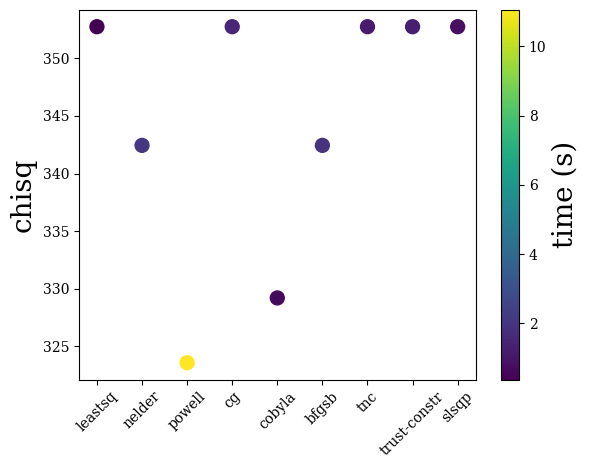

In [62]:
plt.scatter(np.arange(len(labellist)), chisqlist, c=timelist, s=100)
plt.xticks(np.arange(len(labellist)), labellist, rotation=45)
cbar = plt.colorbar()
cbar.ax.set_ylabel('time (s)')
plt.ylabel('chisq')